C:\Users\kurtk\AppData\Local\Temp\ipykernel_8448\4264151855.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  drug_see_p1 = drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
c:\Users\kurtk\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\kurtk\AppData\Local\Programs\Python\Python313\Lib\site-package

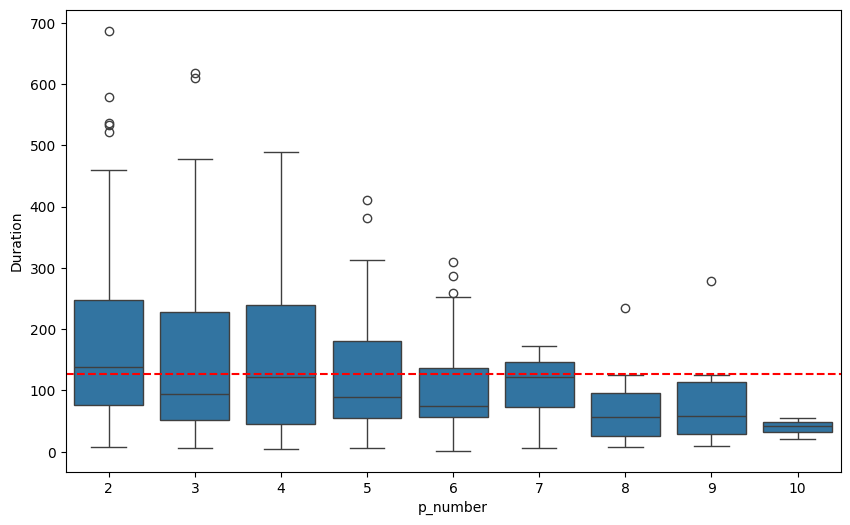

C:\Users\kurtk\AppData\Local\Temp\ipykernel_8448\4264151855.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drug_see2['p_number'] = drug_see2.groupby('pnr').cumcount() + 1


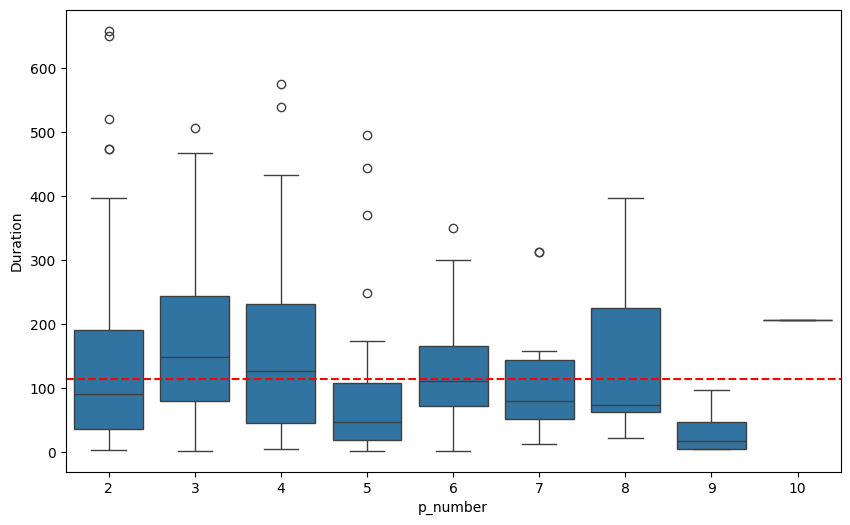

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns

# Sample data equivalent to med.events
data = {
  'pnr': np.random.randint(1, 100, 1000),
  'eksd': pd.date_range(start='1/1/2020', periods=1000, freq='D'),
  'perday': np.random.randint(1, 10, 1000),
  'ATC': np.random.choice(['medA', 'medB'], 1000),
  'dur_original': np.random.randint(1, 30, 1000)
}
example_pats = pd.DataFrame(data)

def see(arg1):
  c09ca01 = example_pats[example_pats['ATC'] == arg1]
  drug_see_p0 = c09ca01.copy()
  drug_see_p1 = c09ca01.copy()
  drug_see_p1 = drug_see_p1.sort_values(by=['pnr', 'eksd'])
  drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
  drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd'])
  drug_see_p1 = drug_see_p1.groupby('pnr').apply(lambda x: x.sample(1)).reset_index(drop=True)
  drug_see_p1['event_interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days
  ecdf = drug_see_p1['event_interval'].value_counts().sort_index().cumsum() / len(drug_see_p1)
  dfper = ecdf[ecdf <= 0.8].reset_index()
  dfper.columns = ['x', 'y']
  ni = dfper['x'].max()
  drug_see_p2 = drug_see_p1[drug_see_p1['event_interval'] <= ni]
  density = gaussian_kde(np.log(drug_see_p2['event_interval']))
  x = np.linspace(np.log(drug_see_p2['event_interval']).min(), np.log(drug_see_p2['event_interval']).max(), 1000)
  y = density(x)
  a = pd.DataFrame({'x': x, 'y': y})
  a = StandardScaler().fit_transform(a)
  silhouette_avg = silhouette_score(a, KMeans(n_clusters=2, random_state=1234).fit_predict(a))
  cluster = KMeans(n_clusters=2, random_state=1234).fit(dfper[['x']])
  dfper['cluster'] = cluster.labels_
  ni2 = dfper.groupby('cluster')['x'].min()
  ni3 = dfper.groupby('cluster')['x'].max()
  ni4 = dfper.groupby('cluster')['x'].median()
  nif = pd.DataFrame({'Cluster': ni2.index, 'Minimum': ni2.values, 'Maximum': ni3.values, 'Median': ni4.values})
  results = drug_see_p1.merge(nif, how='cross')
  results['Final_cluster'] = np.where((results['event_interval'] >= results['Minimum']) & (results['event_interval'] <= results['Maximum']), results['Cluster'], np.nan)
  results = results.dropna(subset=['Final_cluster'])
  results['Median'] = np.exp(results['Median'])
  t1 = results['Cluster'].value_counts().idxmax()
  t1_merged = results[results['Cluster'] == t1].iloc[0]
  drug_see_p1 = drug_see_p1.merge(results[['pnr', 'Median', 'Cluster']], on='pnr', how='left')
  drug_see_p1['Median'] = drug_see_p1['Median'].fillna(t1_merged['Median'])
  drug_see_p1['Cluster'] = drug_see_p1['Cluster'].fillna(0)
  drug_see_p1['test'] = np.round(drug_see_p1['event_interval'] - drug_see_p1['Median'], 1)
  drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster']]
  drug_see_p0 = drug_see_p0.merge(drug_see_p3, on='pnr', how='left')
  drug_see_p0['Median'] = drug_see_p0['Median'].fillna(t1_merged['Median'])
  drug_see_p0['Cluster'] = drug_see_p0['Cluster'].fillna(0)
  return drug_see_p0

def see_assumption(arg1):
  arg1 = arg1.sort_values(by=['pnr', 'eksd'])
  arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
  drug_see2 = arg1.dropna(subset=['prev_eksd'])
  drug_see2['p_number'] = drug_see2.groupby('pnr').cumcount() + 1
  drug_see2 = drug_see2[drug_see2['p_number'] >= 2]
  drug_see2['Duration'] = (drug_see2['eksd'] - drug_see2['prev_eksd']).dt.days
  medians_of_medians = drug_see2.groupby('pnr')['Duration'].median().median()
  plt.figure(figsize=(10, 6))
  sns.boxplot(x='p_number', y='Duration', data=drug_see2)
  plt.axhline(medians_of_medians, linestyle='--', color='red')
  plt.show()

med_a = see("medA")
med_b = see("medB")

see_assumption(med_a)
see_assumption(med_b)
